In [1]:
import sys, os
sys.path.append('../')
sys.path.append('../src/')

import torch
import numpy as np
import utils
from torch.nn import Module, Parameter
import torch.optim as opt
from utils import preprocess
import torch.nn.functional as F

import torch.optim as opt
from torch import softmax, log_softmax, Tensor
from sklearn.cluster import KMeans


from sklearn.decomposition import PCA
from umap_batch import UMAP
from utils import re_nn_distance, re_distance_nn

import pandas as pd  
import scipy.sparse as sp
import model
import time

import quantile 

import coupleNMF as coupleNMF

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



# CFRM_vanilla

In [2]:
# read in dataset
dir = '../data/real/diag/Xichen/'

counts_rnas = []
counts_atacs = []
counts_proteins = []
for batch in [1, 2]:
    try:
        counts_atac = np.array(sp.load_npz(os.path.join(dir, 'RxC' + str(batch) + ".npz")).todense().T)
        counts_atac = utils.preprocess(counts_atac, modality = "ATAC")

    except:
        counts_atac = None
        
    try:
        counts_rna = np.array(sp.load_npz(os.path.join(dir, 'GxC' + str(batch) + ".npz")).todense().T)
        counts_rna = utils.preprocess(counts_rna, modality = "RNA")
    
    except:
        counts_rna = None
    
    # preprocess the count matrix
    counts_rnas.append(counts_rna)
    counts_atacs.append(counts_atac)

counts = {"rna":counts_rnas, "atac": counts_atacs}

A = sp.load_npz(os.path.join(dir, 'GxR.npz'))
A = np.array(A.todense())
# normalize A
A = utils.preprocess(A, modality = "interaction")
interacts = {"rna_atac": A}


# obtain the feature name
genes = pd.read_csv(dir + "genes.txt", header = None).values.squeeze()
regions = pd.read_csv(dir + "regions.txt", header = None).values.squeeze()

feats_name = {"rna": genes, "atac": regions}
counts["feats_name"] = feats_name

# K = 30

Input sanity check...
Finished.
Epoch 1000, Validating Loss: 78.4758
	 loss 1: 0.08330
	 loss 2: 0.00056
	 loss 3: -0.96442
Epoch 2000, Validating Loss: 77.6742
	 loss 1: 0.08251
	 loss 2: 0.00246
	 loss 3: -0.96811
Epoch 3000, Validating Loss: 77.3872
	 loss 1: 0.08224
	 loss 2: 0.00279
	 loss 3: -0.97069
Epoch 4000, Validating Loss: 77.2206
	 loss 1: 0.08208
	 loss 2: 0.00216
	 loss 3: -0.97213
Epoch 5000, Validating Loss: 77.1022
	 loss 1: 0.08196
	 loss 2: 0.00228
	 loss 3: -0.97292
Epoch 6000, Validating Loss: 76.9963
	 loss 1: 0.08186
	 loss 2: 0.00255
	 loss 3: -0.97387
running time: 84.72579169273376


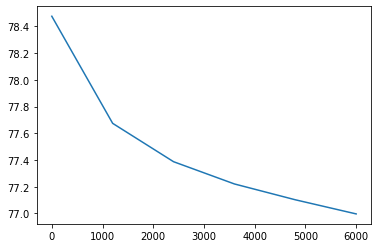

In [3]:
#hyper parameters: best lr = 5e-3, T = 4000, latent_dims = 13
alpha = [1000, 1, 5]
batchsize = 0.1
run = 0
K = 30
Ns = [K] * 2
N_feat = Ns[0]
interval = 1000
T = 6000
lr = 1e-2

# use interaction matrix
start_time = time.time()
model1 = model.cfrm_vanilla(counts = counts, interacts = interacts, Ns = Ns, K = K, N_feat = N_feat, batch_size = batchsize, interval = interval, lr = lr, alpha = alpha, seed = run).to(device)
losses1 = model1.train_func(T = T)
end_time = time.time()
print("running time: " + str(end_time - start_time))

x = np.linspace(0, T, int(T/interval))
plt.plot(x, losses1)

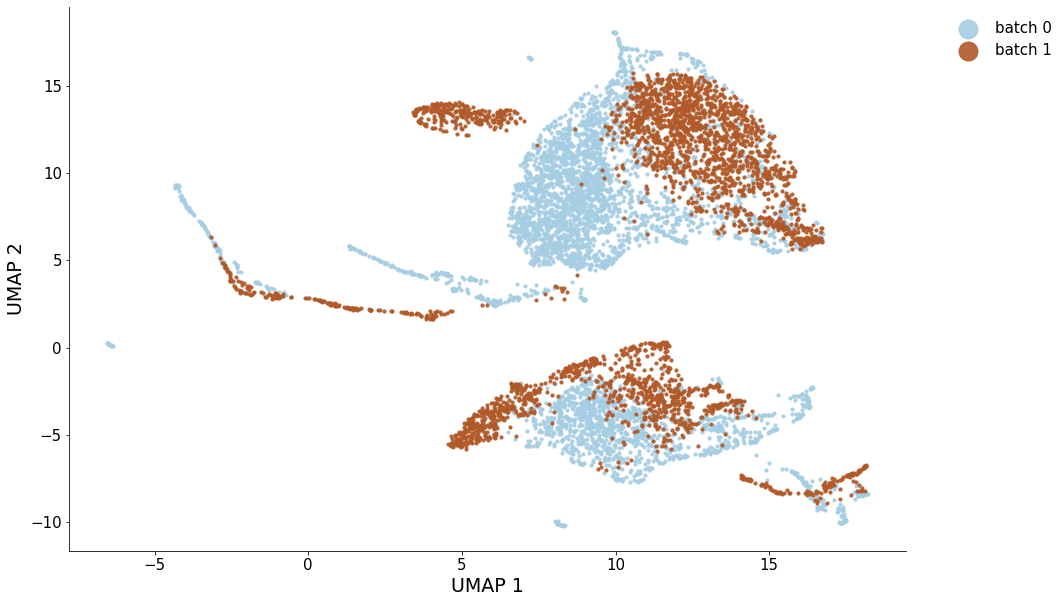

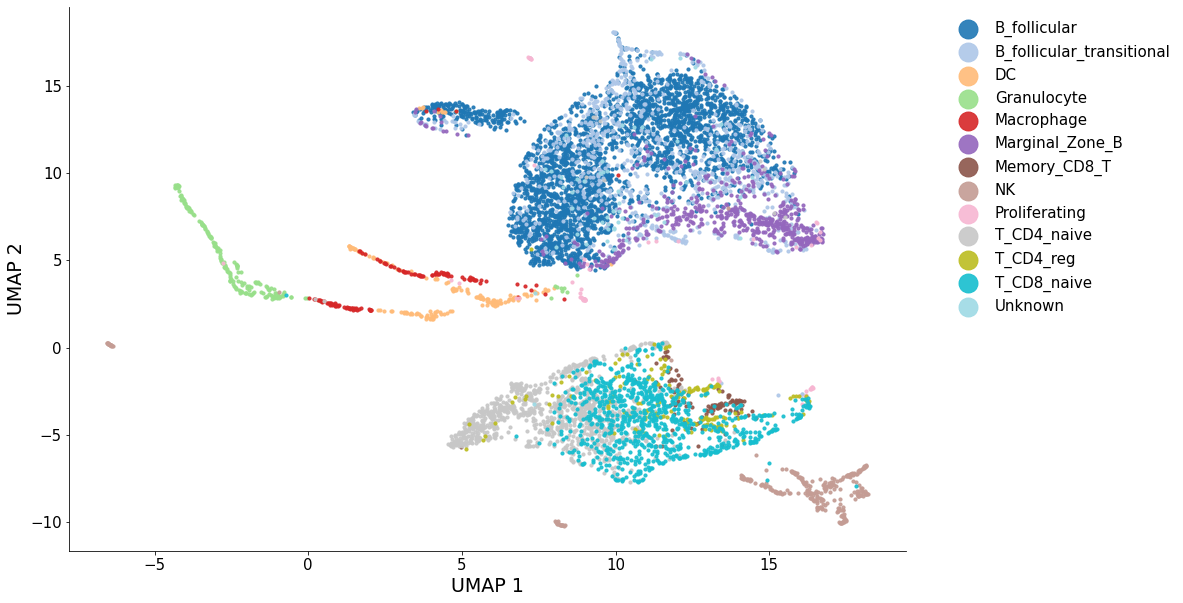

In [4]:
umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4, random_state = 0) 
zs = []
labels = []
prec_labels = []
pre_labels = []
for batch in range(0,2):
    z = model1.softmax(model1.C_cells[str(batch)].cpu().detach()).numpy()
    # z = model1.C_cells[batch].cpu().detach().numpy()
    zs.append(z)
    labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch + 1) + '.csv'), index_col=0)["cell_type"].values.squeeze())
    pre_labels.append(np.argmax(z, axis = 1).squeeze())

x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0))
# separate into batches
x_umaps = []
for batch in range(0,2):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == 1:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

# utils.plot_latent_ext(x_umaps, annos = labels, mode = "separate", save = None, figsize = (10,15), axis_label = "UMAP")

utils.plot_latent_ext(x_umaps, annos = labels, mode = "modality", save = None, figsize = (15,10), axis_label = "UMAP", markerscale = 6)

utils.plot_latent_ext(x_umaps, annos = labels, mode = "joint", save = None, figsize = (15,10), axis_label = "UMAP", markerscale = 6)


# Post-processing

## Method A 

Modify pairwise distance and then assign knn_indices and knn_distance

In [5]:
# cannot be set to be too large, or the heterogenity of cells within the cluster is lost
# number of neighbors have larger-effect on method A compared to method B.
n_neighbors = 10

../src/umap_batch.py:1746: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


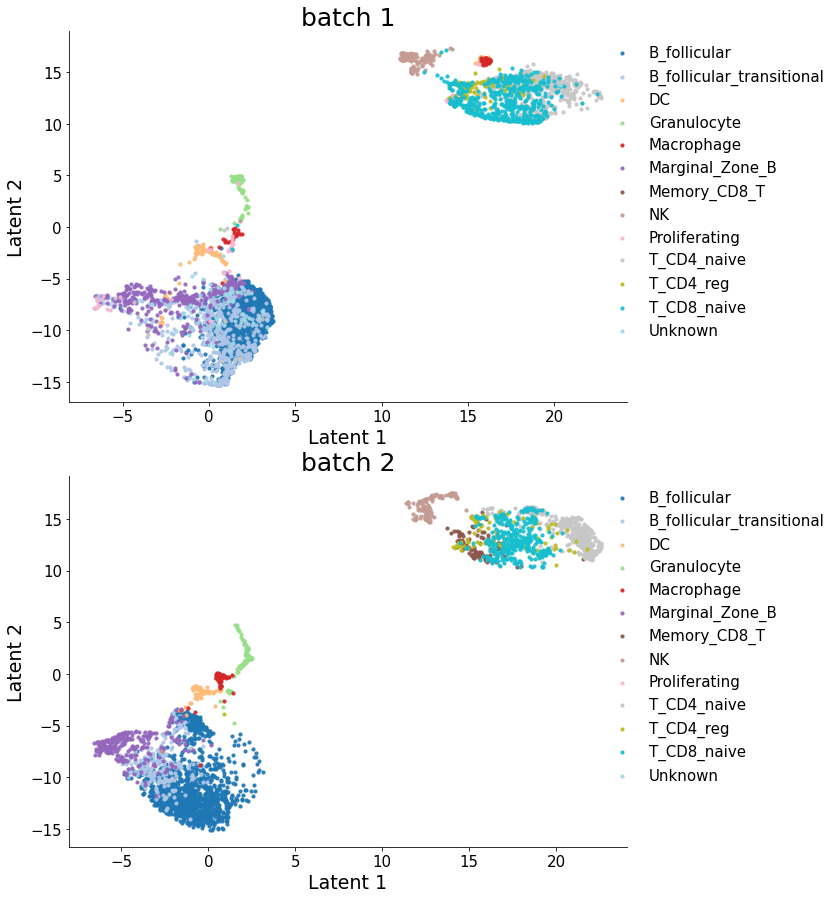

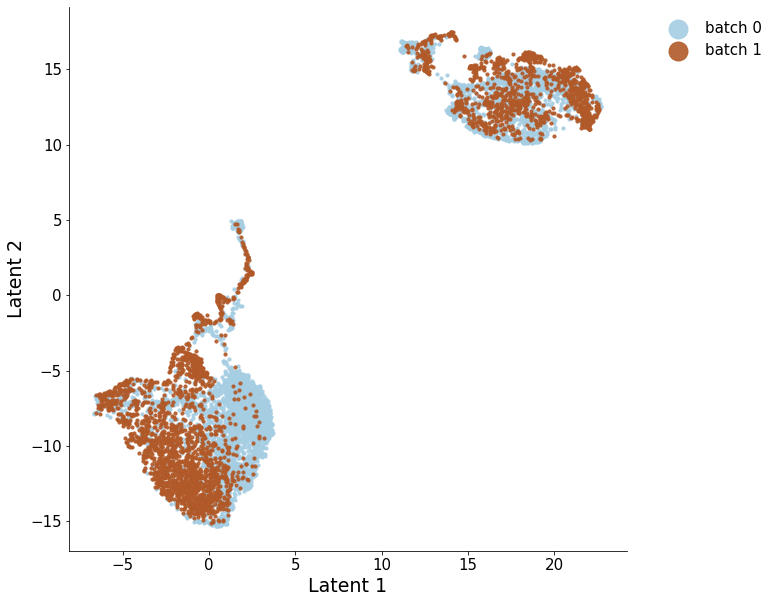

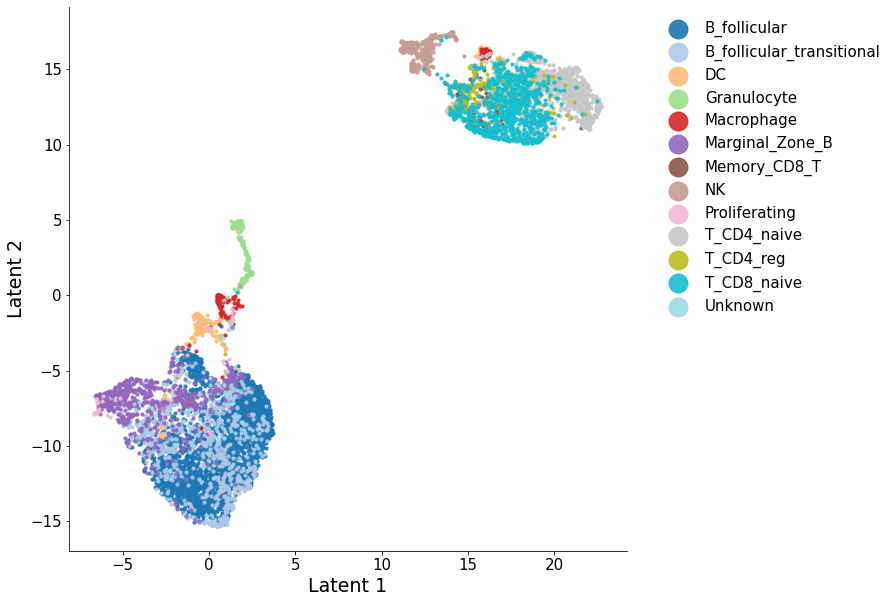

In [56]:
zs = []
labels = []
prec_labels = []
pre_labels = []
for batch in range(0,2):
    z = model1.softmax(model1.C_cells[str(batch)].cpu().detach()).numpy()
    # z = model1.C_cells[batch].cpu().detach().numpy()
    zs.append(z)
    labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch + 1) + '.csv'), index_col=0)["cell_type"].values.squeeze())
    pre_labels.append(np.argmax(z, axis = 1).squeeze())


s_pair_dist, knn_indices, knn_dists = re_distance_nn(zs, n_neighbors)

umap_op = UMAP(n_components = 2, n_neighbors = n_neighbors, min_dist = 0.4, random_state = 0, 
                metric='precomputed', knn_dists=knn_dists, knn_indices=knn_indices) 
x_umap = umap_op.fit_transform(s_pair_dist)
# separate into batches
x_umaps = []
for batch in range(0,2):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == 1:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

utils.plot_latent_ext(x_umaps, annos = labels, mode = "separate", save = None, 
                      figsize = (10,15), axis_label = "Latent")

utils.plot_latent_ext(x_umaps, annos = labels, mode = "modality", save = None, 
                      figsize = (10,10), axis_label = "Latent", markerscale = 6)

utils.plot_latent_ext(x_umaps, annos = labels, mode = "joint", save = None, 
                      figsize = (10,10), axis_label = "Latent", markerscale = 6)



## Method B

compute knn_indices first and then modify distance matrix

../src/umap_batch.py:1746: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


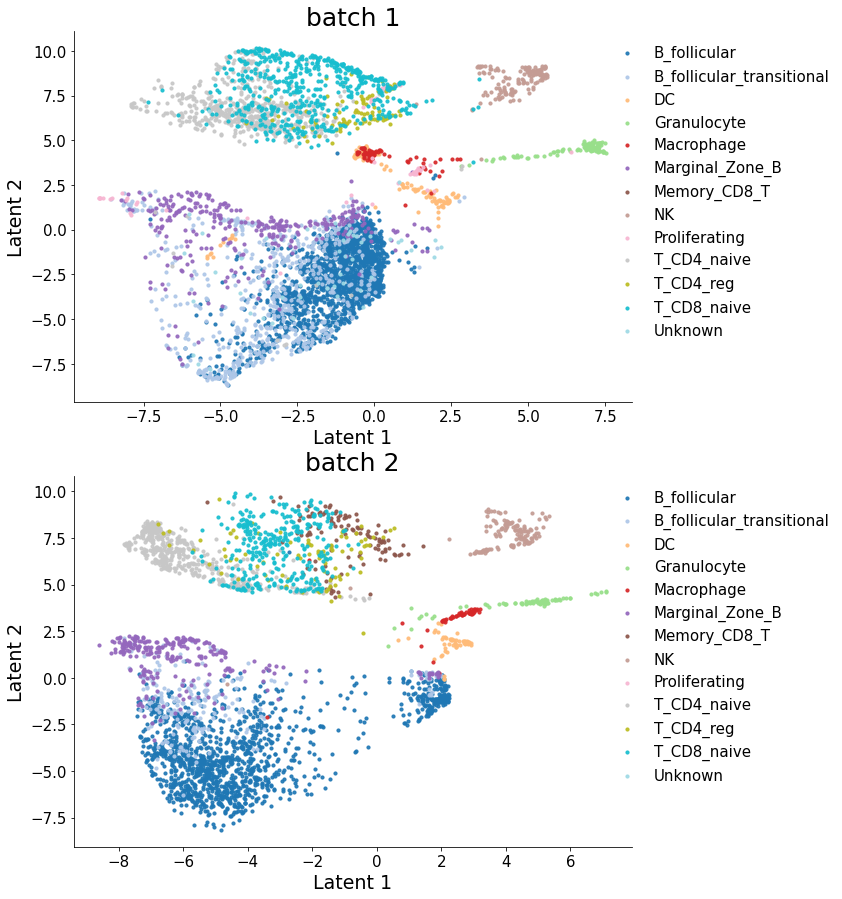

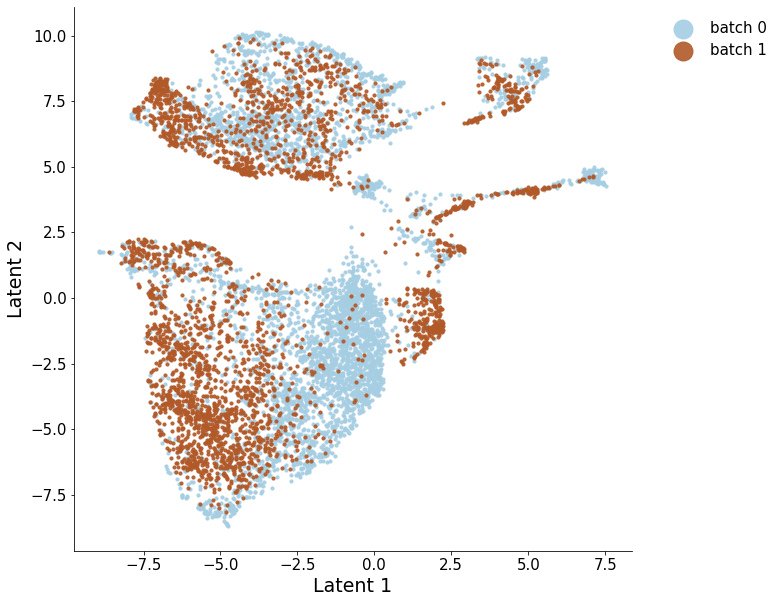

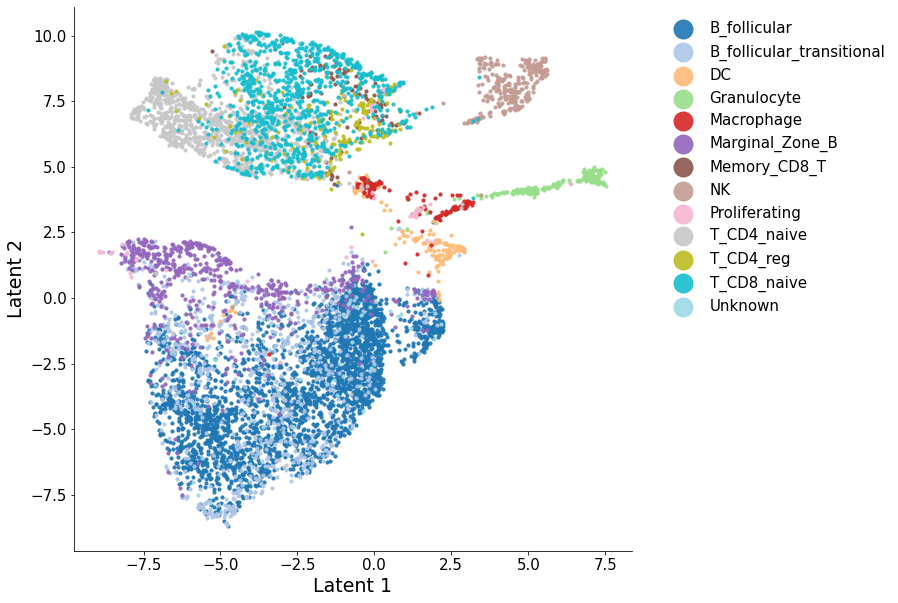

In [6]:
zs = []
labels = []
prec_labels = []
pre_labels = []
for batch in range(0,2):
    z = model1.softmax(model1.C_cells[str(batch)].cpu().detach()).numpy()
    # z = model1.C_cells[batch].cpu().detach().numpy()
    zs.append(z)
    labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch + 1) + '.csv'), index_col=0)["cell_type"].values.squeeze())
    pre_labels.append(np.argmax(z, axis = 1).squeeze())

s_pair_dist, knn_indices, knn_dists = re_nn_distance(zs, n_neighbors)

umap_op = UMAP(n_components = 2, n_neighbors = n_neighbors, min_dist = 0.4, random_state = 0, 
                metric='precomputed', knn_dists=knn_dists, knn_indices=knn_indices)
x_umap = umap_op.fit_transform(s_pair_dist)
# separate into batches
x_umaps = []
for batch in range(0,2):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == 1:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

utils.plot_latent_ext(x_umaps, annos = labels, mode = "separate", save = None, 
                      figsize = (10,15), axis_label = "Latent")

utils.plot_latent_ext(x_umaps, annos = labels, mode = "modality", save = None, 
                      figsize = (10,10), axis_label = "Latent", markerscale = 6)

utils.plot_latent_ext(x_umaps, annos = labels, mode = "joint", save = None, 
                      figsize = (10,10), axis_label = "Latent", markerscale = 6)


# Clustering cells & marker features

* First cluster the cell using the cell factors, Leiden algorithm can be used. Since cell-cell graph is already given. The cluster algorithm can run directly on the graph.
* Then give hard assignment of cells according to their cluster results. Retrain the model:
    * The cluster order is arbitrary, possibily need to randomly reinitialize all factors.
    * The softmax function is added to the Cell factors, 0 values in binary assignment will have non-zero values after softmax.

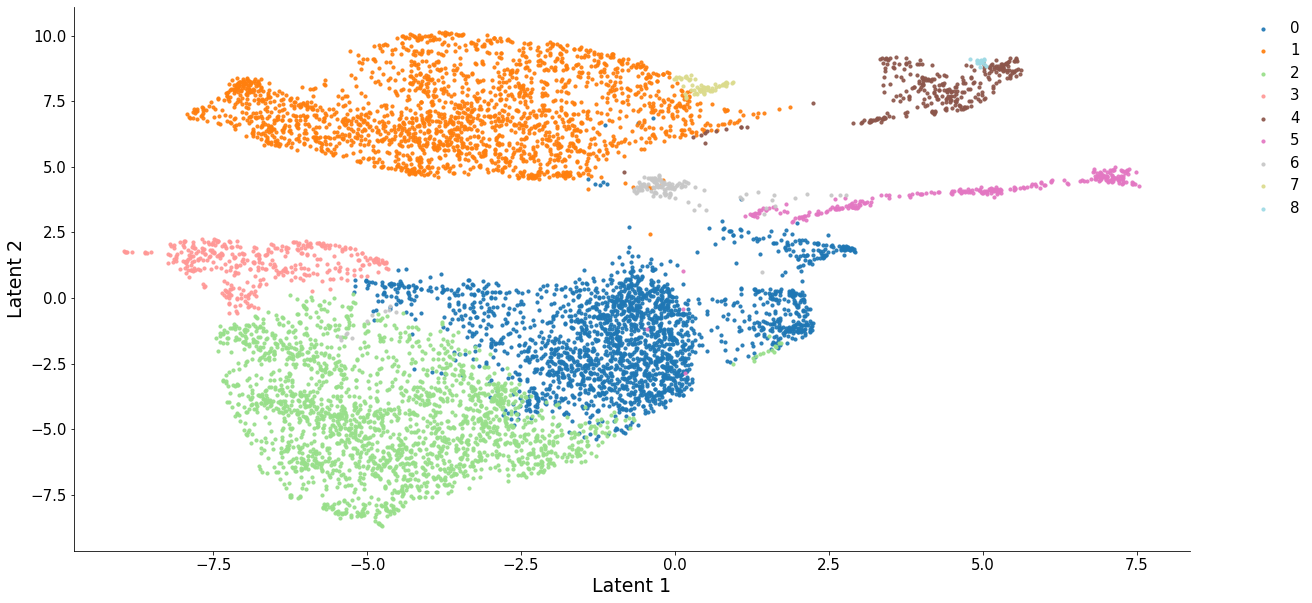

In [16]:
zs = []
labels = []
pre_labels = []
for batch in range(2):
    z = model1.softmax(model1.C_cells[str(batch)].cpu().detach()).numpy()
    zs.append(z)
    labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch + 1) + '.csv'), index_col=0)["cell_type"].values.squeeze())
    pre_labels.append(np.argmax(z, axis = 1).squeeze())

[s_pair_dist, knn_indices, knn_dists] = re_nn_distance(zs, n_neighbors = 30)
labels_tmp = utils.leiden_cluster(X = None, knn_indices = knn_indices, knn_dists = knn_dists, resolution = 0.3)

leiden_labels = []
for batch in range(2):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        leiden_labels.append(labels_tmp[start_pointer:end_pointer])
        
    elif batch == 1:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        leiden_labels.append(labels_tmp[start_pointer:])

    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        leiden_labels.append(labels_tmp[start_pointer:end_pointer])

utils.plot_latent_ext(x_umaps, annos = leiden_labels, mode = "joint", save = None, 
                      figsize = (20,10), axis_label = "Latent")

In [17]:
model2 = model.cfrm_retrain(model = model1, labels = leiden_labels).to(device)
losses = model2.train(T = 1000)

Epoch 1000, Validating Loss: 78.3609
	 loss 1: 0.08322
	 loss 2: 0.00142
	 loss 3: -0.97281


In [18]:
C_feats = {}
for mod in model2.mods:
    C_feat = model2.softmax(model2.C_feats[mod]).data.cpu().numpy() @ model2.A_assos["shared"].data.cpu().numpy().T 
    C_feats[mod] = pd.DataFrame(data = C_feat, index = model2.feats_name[mod], columns = ["cluster_" + str(i) for i in range(C_feat.shape[1])])

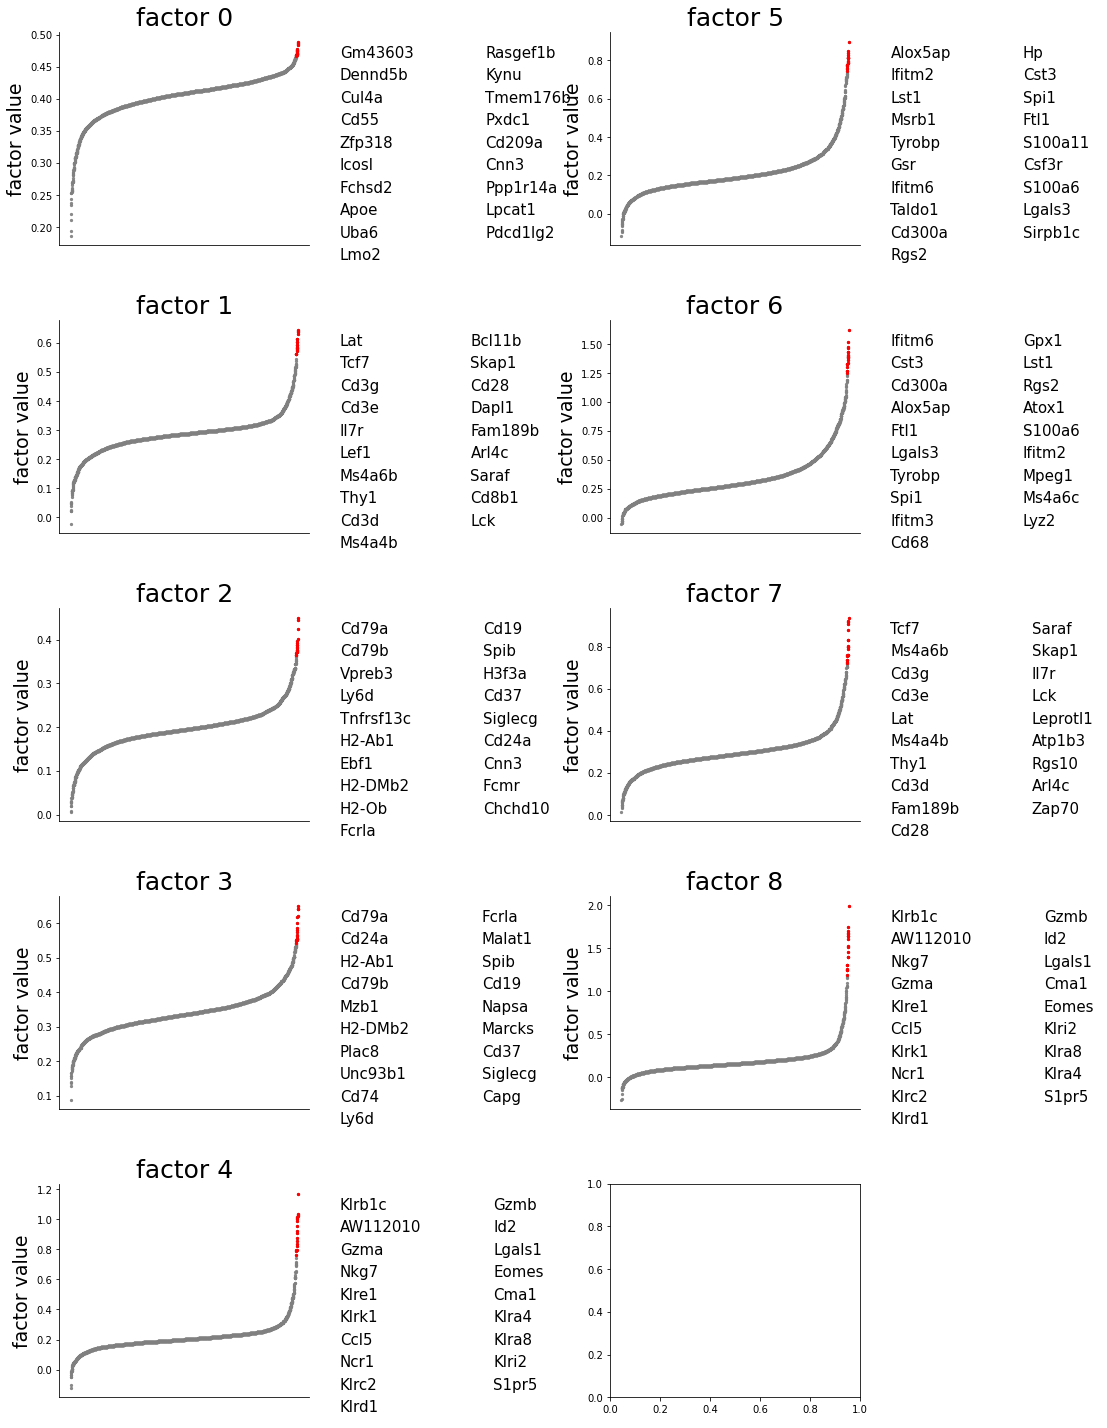

In [19]:
C_gene = C_feats["rna"]
utils.plot_feat_score(C_gene, n_feats = 20, figsize= (15,20), save_as = None, title = None)
